#### Let's import the libraries

In [1]:
from tensorflow import keras
import numpy as np
import tarfile
from time import time
from tensorflow.keras.applications import resnet50, vgg19, mobilenet_v2, xception, resnet
import matplotlib.pyplot as plt
import pandas as pd
import datetime, os
import pathlib
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.applications import inception_v3
from IPython import display
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers

# Load the TensorBoard notebook extension
%load_ext tensorboard

## Preprocessing
#### Create train and test set

In [2]:
train_dir = "data_mel/train" 
val_dir = "data_mel/val"
test_dir = "data_mel/test"

In [3]:
species = np.array(tf.io.gfile.listdir(str(train_dir)))
species = species[species != 'README.md']
n_classes= len(species)
print('Species:', species)

Species: ['Alces_alces' 'Bos_taurus' 'Cervus_elaphus' 'Equus_caballus'
 'Lutra_lutra' 'Ovis' 'Pan' 'Panthera_leo' 'Procyon' 'Vulpes']


#### Defining imagedatagenerators

In [4]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= resnet.preprocess_input)



train_generator = train_processing.flow_from_directory(directory = train_dir,
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1234)

Found 916 images belonging to 10 classes.


In [5]:
val_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

val_generator = val_processing.flow_from_directory(
        directory=val_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=True
)

Found 119 images belonging to 10 classes.


In [6]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=resnet.preprocess_input)

test_generator = test_processing.flow_from_directory(
        directory=test_dir,
        target_size=(224, 224),
        color_mode="rgb",
        batch_size=32,
        class_mode="categorical",
        shuffle=False
)

Found 148 images belonging to 10 classes.


#### Let's define the weights for each class

In [7]:
dict_classes = {}
for class_el in os.listdir(train_dir):
    dict_classes[class_el] = len(os.listdir(f"{train_dir}/{class_el}"))

dict_classes

{'Alces_alces': 70,
 'Bos_taurus': 215,
 'Cervus_elaphus': 105,
 'Equus_caballus': 80,
 'Lutra_lutra': 120,
 'Ovis': 70,
 'Pan': 66,
 'Panthera_leo': 70,
 'Procyon': 44,
 'Vulpes': 76}

In [8]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
total = 916

weight_for_0 = (1 / 70)*(total)/10.0 
weight_for_1 = (1 / 215)*(total)/10.0
weight_for_2 = (1 / 105)*(total)/10.0 
weight_for_3 = (1 / 80)*(total)/10.0
weight_for_4 = (1 / 120)*(total)/10.0 
weight_for_5 = (1 / 70)*(total)/10.0
weight_for_6 = (1 / 66)*(total)/10.0 
weight_for_7 = (1 / 70)*(total)/10.0
weight_for_8 = (1 / 44)*(total)/10.0 
weight_for_9 = (1 / 76)*(total)/10.0

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5, 6: weight_for_6, 7: weight_for_7, 8: weight_for_8, 9: weight_for_9}

## Modelling
#### Import ResNet

In [59]:
base_net = resnet.ResNet101(weights="imagenet", include_top=False,
	input_shape=(224, 224, 3), pooling="avg")

In [60]:
for layer in base_net.layers:
    layer.trainable = False

#### Create our models as a combination of Resnet and other layers 

In [62]:
# Output of the base_net model
x = base_net.output
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(200, activation='relu', kernel_regularizer=regularizers.l2(l2=0.0005))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.ReLU()(x)
x = keras.layers.BatchNormalization()(x)
pred = keras.layers.Dense(n_classes, activation='softmax')(x)

In [63]:
model = keras.Model(inputs=base_net.input, outputs=pred)

#### Compile the model with Categorical crossentropy as loss, Adam as optimizer and accuracy as metric

In [65]:
model.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.Adam(lr=0.001),
            metrics=['accuracy'])

## Training

In [66]:
cp_callback = keras.callbacks.ModelCheckpoint(filepath="monodim_weights",
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 monitor="val_accuracy",
                                                 verbose=1)

from tensorflow.keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    if epoch > 7:
        lr = 0.001
    if epoch > 17:
        lr = 0.0007
    return lr

In [67]:
history1 = model.fit(train_generator,
          epochs=50,
          validation_data=val_generator,
          callbacks=[cp_callback, LearningRateScheduler(lr_scheduler, verbose=1)], class_weight=class_weight)

Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
29/29 [==============================] - 17s 372ms/step - loss: 2.9260 - accuracy: 0.1755 - val_loss: 1.7101 - val_accuracy: 0.4370

Epoch 00001: val_accuracy improved from -inf to 0.43697, saving model to monodim_weights
Epoch 2/50

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
29/29 [==============================] - 9s 294ms/step - loss: 1.6298 - accuracy: 0.4973 - val_loss: 1.4740 - val_accuracy: 0.5630

Epoch 00002: val_accuracy improved from 0.43697 to 0.56303, saving model to monodim_weights
Epoch 3/50

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0010000000474974513.
29/29 [==============================] - 8s 291ms/step - loss: 1.3024 - accuracy: 0.5998 - val_loss: 1.3492 - val_accuracy: 0.6471

Epoch 00003: val_accuracy improved from 0.56303 to 0.64706, saving model to monodim_weights
Epoch 4/50

Epoch 00004: LearningRateSched

In [68]:
load_status = model.load_weights("monodim_weights")
load_status.assert_consumed()

## Results

In [69]:
# Confusion matrix
def c_matrix(y_val, y_pred, classes):
    cm = confusion_matrix(y_val, y_pred)
    fig, ax= plt.subplots(figsize = (8,6))
    sns.heatmap(cm, annot=True, annot_kws={"size": 10},
               linewidths=.2, fmt="d", cmap="PuBu")
    plt.xlabel("True Class", size = 12, horizontalalignment="right")
    plt.ylabel("Predicted Class", size = 12)
    ax.set_yticklabels(classes, rotation = 45, fontdict= {'fontsize': 10})
    ax.set_xticklabels(classes, rotation = 30, fontdict= {'fontsize': 10})
    plt.title("Confusion matrix", size = 20)
    plt.show()


Y_pred = model.predict_generator(test_generator, 148 // 32+1)
y_pred = np.argmax(Y_pred, axis=1)

from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
species = ["Alces_alces", "Bos_taurus", "Cervus_elaphus", "Equus_caballus",
           "Lutra_lutra", "Ovis", "Pan", "Panthera_leo", "Procyon", "Vulpes"]
print('Classification Report')
print(classification_report(test_generator.classes, y_pred, target_names=species))

Classification Report
                precision    recall  f1-score   support

   Alces_alces       1.00      0.50      0.67        12
    Bos_taurus       0.81      0.79      0.80        33
Cervus_elaphus       0.65      0.94      0.77        16
Equus_caballus       0.71      0.71      0.71        14
   Lutra_lutra       0.89      1.00      0.94        16
          Ovis       0.91      0.83      0.87        12
           Pan       0.90      0.82      0.86        11
  Panthera_leo       0.75      0.75      0.75        12
       Procyon       0.67      1.00      0.80         8
        Vulpes       0.80      0.57      0.67        14

      accuracy                           0.79       148
     macro avg       0.81      0.79      0.78       148
  weighted avg       0.81      0.79      0.79       148



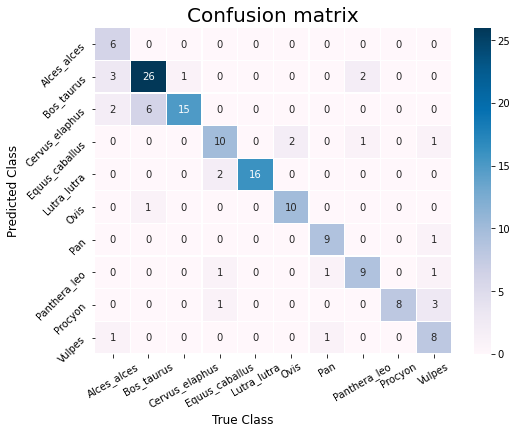

In [70]:
c_matrix(y_pred, test_generator.classes, species)

In [71]:
def accuracy_loss(history):
    plt.figure(figsize=(20,10))
    #
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label = "train_accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="train_accuracy", color ="blue")
    plt.legend(loc='best', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15)
    #
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Test loss", color = "blue")
    plt.legend(loc='best', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15)

In [72]:
performance1 = model.evaluate(test_generator)

5/5 [==============================] - 1s 228ms/step - loss: 0.8839 - accuracy: 0.7905


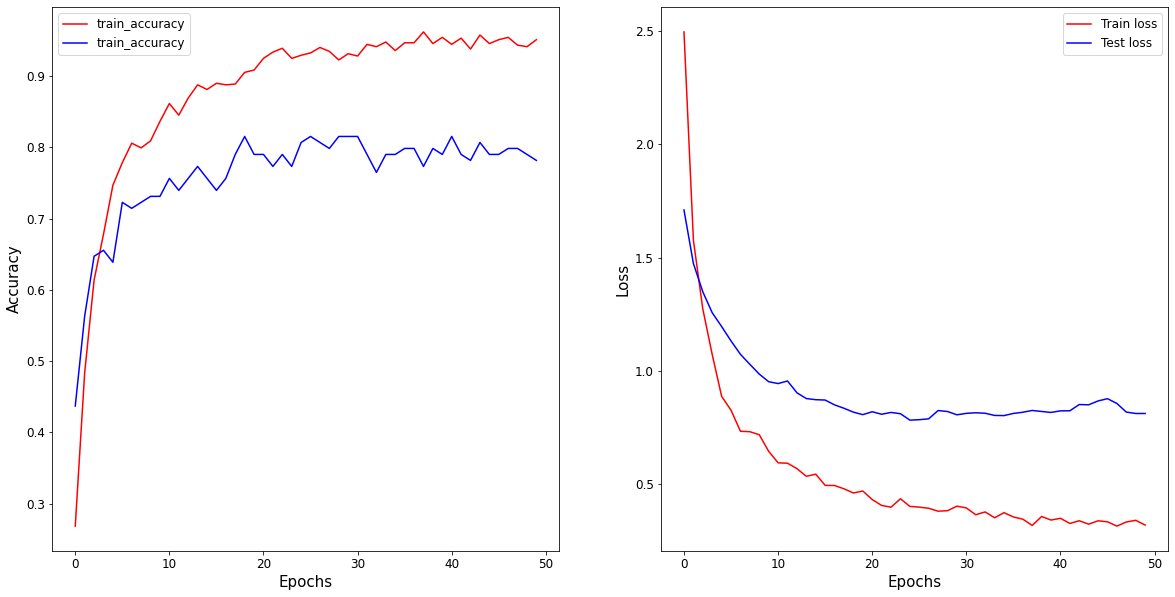

In [73]:
accuracy_loss(history1)